In [3]:
import numpy as np
np.__version__ = '1.24.3'  # Force compatible version
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import logging
import pickle
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from colorama import Fore, Style
from pmdarima import auto_arima
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    MinMaxScaler
)
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from datetime import datetime, date 

logger = logging.getLogger()
logger.setLevel(logging.ERROR)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
df_raw = pd.read_csv('/workspaces/time_series_2/data/raw/Aquifer_Petrignano.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


 
  # Aquifer Petrignano
  

#### A study to predict the groundwater level  
  
Features:  
  
Rainfall indicates the quantity of rain falling (mm)  
Temperature indicates the temperature (°C)  
Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )  
Hydrometry indicates the groundwater level (m)  

Target:
Depth to Groundwater indicates the groundwater level (m from the ground floor)

In [ ]:
df_raw.sample(10,random_state=2025)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [ ]:
df_baking = df_raw.copy()
# Remove old rows
df_baking = df_baking[df_baking.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

#Depth to Groundwater P24 is for a second aquifer, we only need 1, dropped temp from petrignano because main target is Bastia_Umbra,
# I saw this in multiple sample repos in kaggle
df_baking = df_baking.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)


df_baking.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']

#date time for date column
df_baking['date'] = pd.to_datetime(df_baking['date'], format = '%d/%m/%Y')

df_baking = df_baking.sort_values(by='date')


| #  | Column Name           | Non-Null Count | Data Type       |
|----|-----------------------|----------------|-----------------|
| 0  | date                  | 4199           | datetime64[ns]  |
| 1  | rainfall              | 4199           | float64         |
| 2  | depth_to_groundwater | 4172           | float64         |
| 3  | temperature           | 4199           | float64         |
| 4  | drainage_volume       | 4198           | float64         |
| 5  | river_hydrometry      | 4199           | float64         |

  
  
There are some null values in depth_to_groundwater, and drainage_volume, they need to be removed

In [ ]:

df_baking = df_baking.dropna()

df = df_baking.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4171 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  4171 non-null   datetime64[ns]
 1   rainfall              4171 non-null   float64       
 2   depth_to_groundwater  4171 non-null   float64       
 3   temperature           4171 non-null   float64       
 4   drainage_volume       4171 non-null   float64       
 5   river_hydrometry      4171 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 228.1 KB


In [ ]:
print(df.columns)

Index(['date', 'rainfall', 'depth_to_groundwater', 'temperature',
       'drainage_volume', 'river_hydrometry'],
      dtype='object')


In [ ]:
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime if needed
df = df.set_index('date')  # Set as index
df = df.asfreq('D')


train_size = int(len(df) * 0.8)
df_train = df[:train_size]
df_test = df[train_size:]
df_train = df_train.dropna()
df_test = df_train.dropna()

print(f"Train set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Train set: (3343, 5)
Test set: (3343, 5)


In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
rainfall,3343.0,1.459797,5.110548,0.000,0.000,0.000,0.000,67.3
depth_to_groundwater,3343.0,-25.123365,3.259797,-33.710,-27.450,-24.470,-22.890,-19.1
temperature,3343.0,14.809453,7.859705,-3.700,8.450,14.500,21.300,33.0
drainage_volume,3343.0,-29204.717363,4226.899106,-41890.176,-31678.128,-28752.192,-26336.448,0.0
river_hydrometry,3343.0,2.335268,0.639422,0.000,2.000,2.400,2.700,4.1


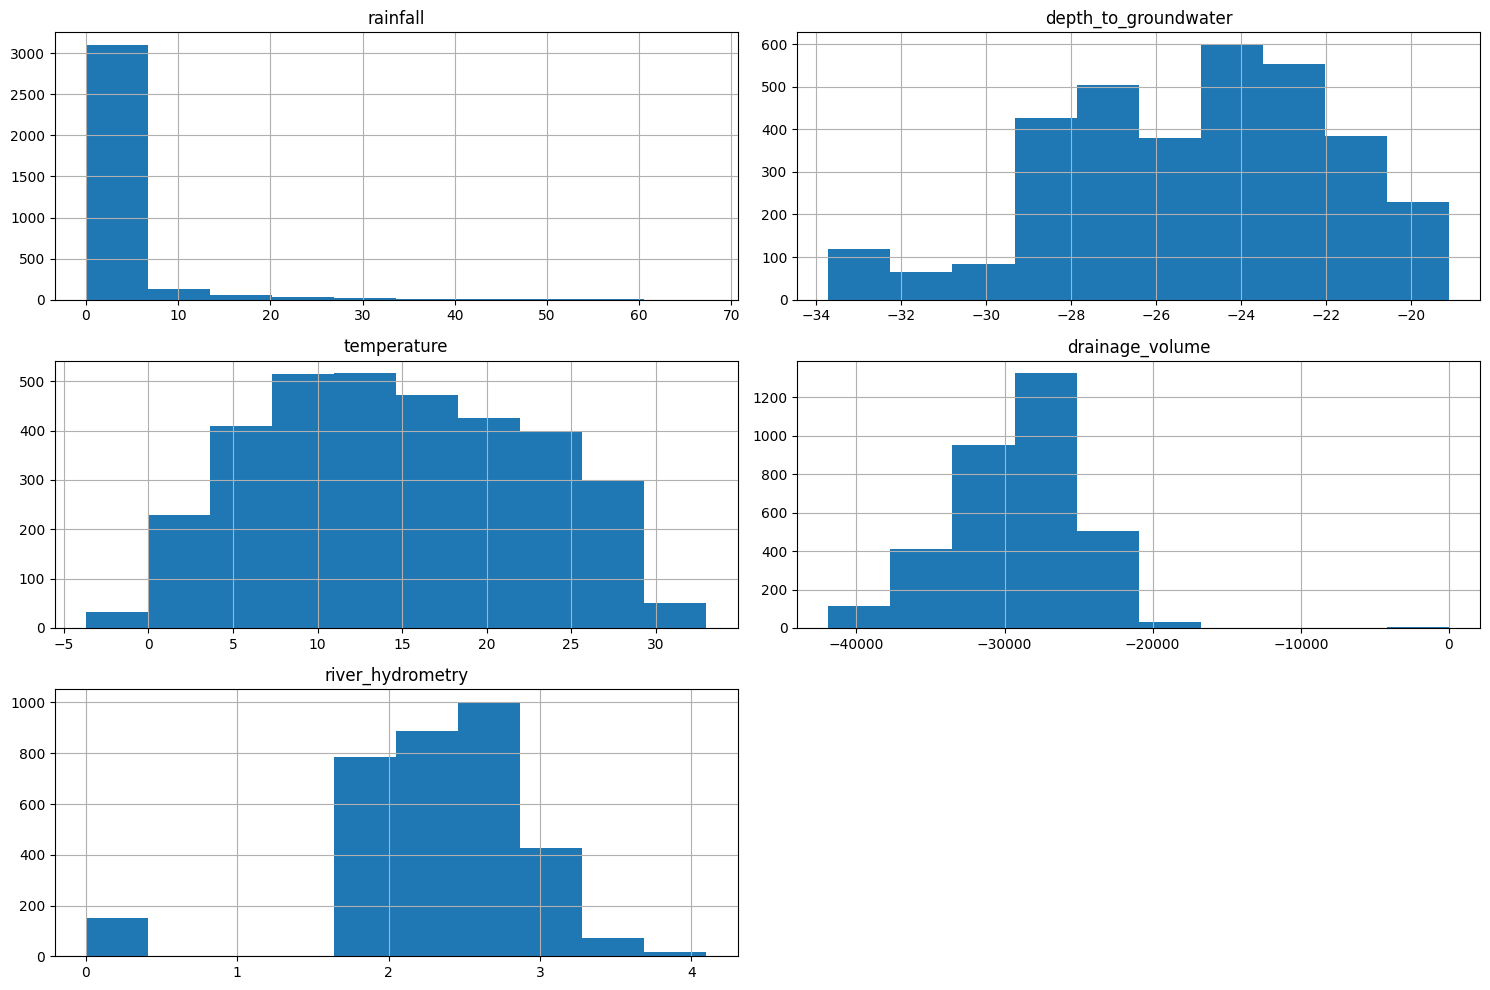

In [ ]:
df_train.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

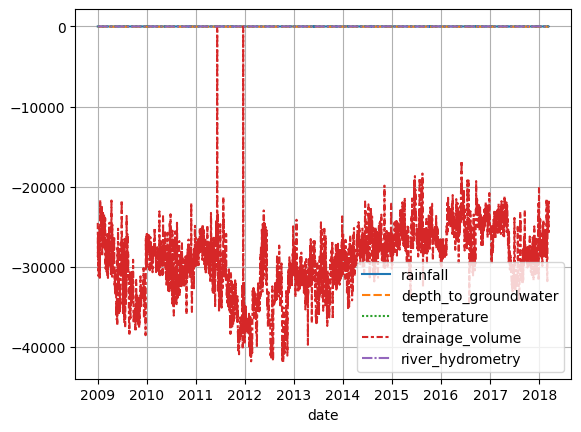

In [ ]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

# Time Series  


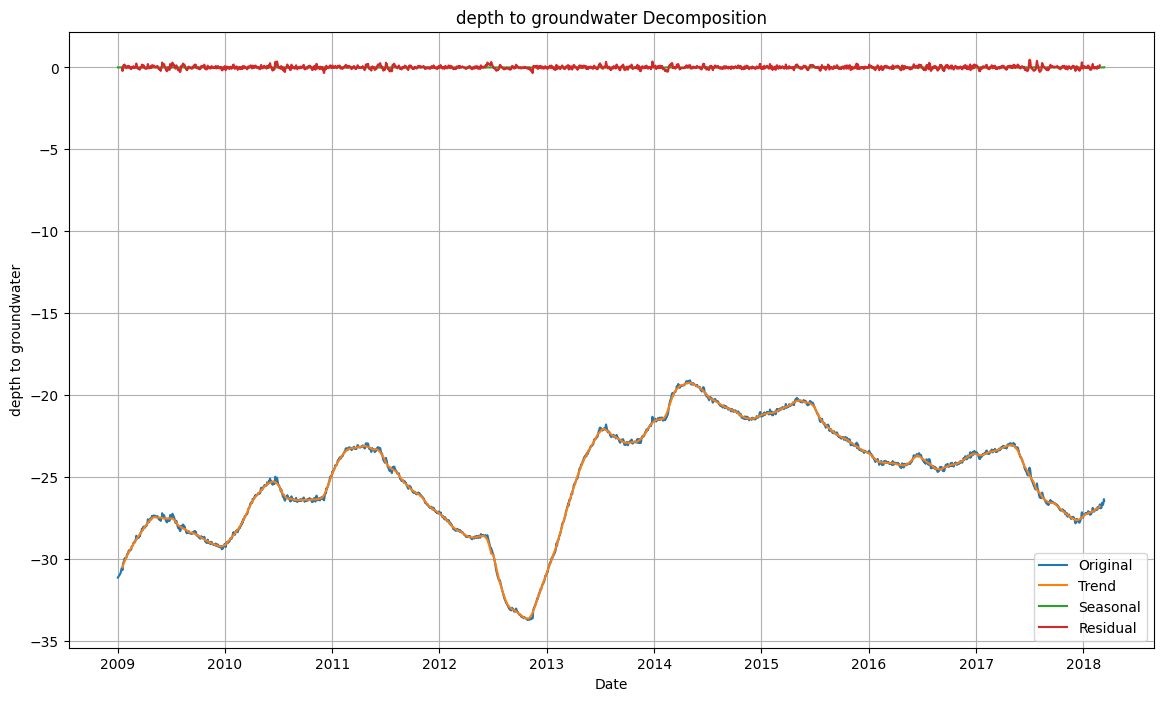

In [ ]:
# Seasonal decomposition
decomposition = seasonal_decompose(df_train['depth_to_groundwater'], period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot all components
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_train['depth_to_groundwater'], label='Original')
sns.lineplot(data=trend, label='Trend')
sns.lineplot(data=seasonal, label='Seasonal')
sns.lineplot(data=residual, label='Residual')
plt.xlabel('Date')
plt.ylabel('depth to groundwater')
plt.title('depth to groundwater Decomposition')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# alpha = 0.05 if the p value is above alpha then we can say that it is not stationary (it has trend)
# if p value < alpha then we can rule out that it is stationary  (it has no trend)
ad_fuller = adfuller(df_train['depth_to_groundwater'])
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -2.49
adf P Value: 0.12


In [ ]:
ad_fuller = adfuller(df_train['depth_to_groundwater'].diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -4.86
adf P Value: 0.00


In [ ]:
ad_fuller = adfuller(df_train['depth_to_groundwater'].diff().diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -19.78
adf P Value: 0.00


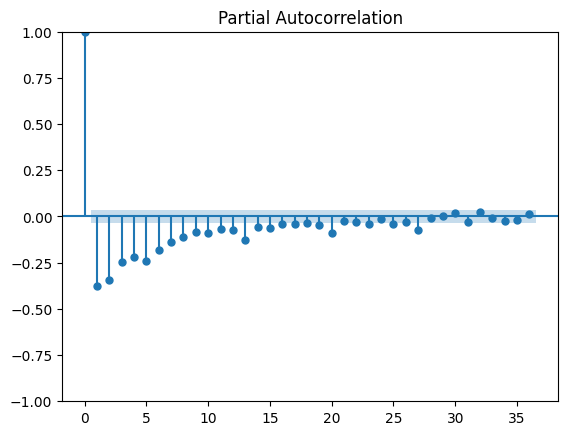

In [ ]:
# value p is the autoregressive term - autoregressive = seasonality
plot_pacf(df_train['depth_to_groundwater'].diff().diff().dropna())
plt.show()

In [ ]:
print(df.index) 

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='date', length=4199, freq='D')


In [ ]:

# 1. Handle missing values
y_train = df_train['depth_to_groundwater'].interpolate(method='time').ffill().bfill()
y_valid = df_test['depth_to_groundwater'].interpolate(method='time').ffill().bfill()

# 2. Use auto_arima to find optimal parameters
model = auto_arima(y_train, 
                   seasonal=True, 
                   m=12,  # Monthly seasonality (adjust as needed)
                   stepwise=True,
                   trace=True)  # Shows search process

print(f"Best ARIMA order: {model.order}")
print(f"Best seasonal order: {model.seasonal_order}")

# 3. Fit model and forecast
model_fit = model.fit(y_train)
y_pred = model_fit.predict(n_periods=len(y_valid))

# 4. Plot results
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_valid.index, y_valid, label='Actual Values')
plt.plot(y_valid.index, y_pred, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actuals')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'auto_arima' is not defined

In [ ]:
print(f"Index frequency: {df.index.freq}")
print(f"Index inferred frequency: {pd.infer_freq(df.index)}")

Index frequency: <Day>
Index inferred frequency: D


NameError: name 'forecast' is not defined

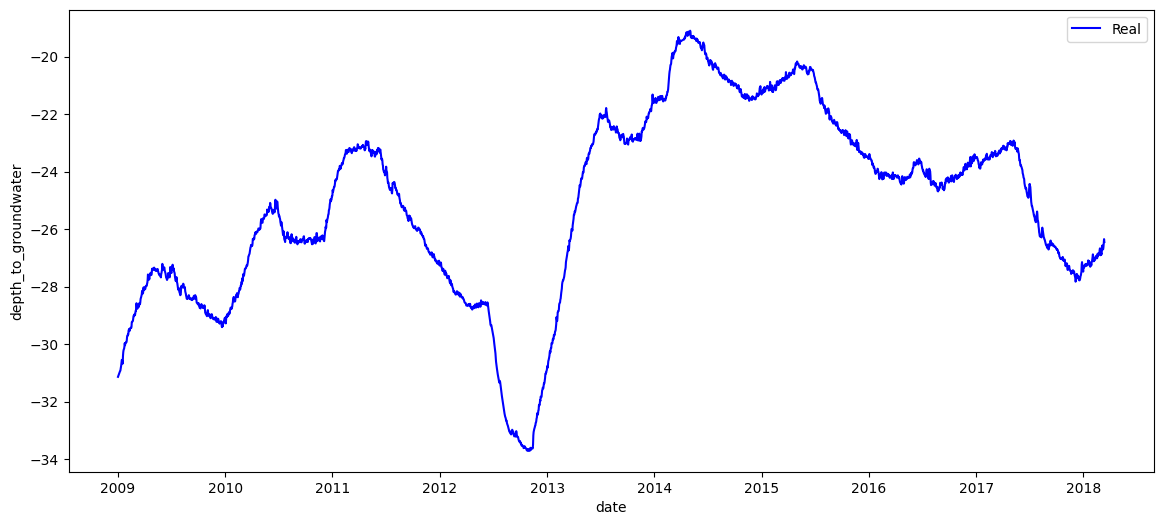

In [ ]:
# Plot the forecast and real test data
plt.figure(figsize=(14, 6))
sns.lineplot(x=df_test.index, y=df_test['depth_to_groundwater'], label='Real', color='blue')

# Create a future index for the forecast values (same as df_test index)
forecast_index = df_test.index

# Plot the forecast values
sns.lineplot(x=forecast_index, y=forecast, label='Forecast', color='red')

plt.title('ARIMA Forecast vs Real Test Data')
plt.xlabel('Date')
plt.ylabel('Flow Rate')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(forecast)
print(df_test['flow_rate_madonna_di_canneto'])


1109    295.921622
1110    295.965194
1111    295.996738
1112    296.004332
1113    295.987492
           ...    
1382    295.948375
1383    295.948375
1384    295.948375
1385    295.948375
1386    295.948375
Name: predicted_mean, Length: 278, dtype: float64
date
2019-09-12    294.596599
2019-09-13    295.880777
2019-09-17    296.757838
2019-09-18    296.649183
2019-09-19    296.639654
                 ...    
2020-06-26    223.919115
2020-06-27    223.861787
2020-06-28    223.764382
2020-06-29    223.766272
2020-06-30    223.752653
Name: flow_rate_madonna_di_canneto, Length: 278, dtype: float64


In [ ]:
print(f"Test data ends at: {df_test.index[-1]}")
print(f"Forecast starts at: {forecast_series.index[0]}")

Test data ends at: 2020-06-30 00:00:00
Forecast starts at: 2020-07-01 00:00:00


## These predictions are notttt accurate at alll

In [ ]:
#---------------

# Random Forest Regression
### Trying something new!

In [ ]:
df_baking = df_baking.dropna(subset=['rainfall_settefrati', 'temperature_settefrati'])

# Feature engineering from date
df_baking['month'] = df_baking['date'].dt.month

df_baking['month'] = df_baking['date'].dt.month.astype('category')

df_baking['date'] = pd.to_datetime(df_baking['date'])
df_baking = df_baking.set_index('date')

# Define the split percentages
train_size = int(len(df_baking) * 0.8)
val_size = int(len(df_baking) * 0.1)
test_size = len(df_baking) - train_size - val_size

# Split the data
df_train_rf = df_baking[:train_size]
df_val_rf = df_baking[train_size:train_size+val_size]
df_test_rf = df_baking[train_size+val_size:]



# Check the shape of each split
print(f"Train set: {df_train_rf.shape}")
print(f"Validation set: {df_val_rf.shape}")
print(f"Test set: {df_test_rf.shape}")
df_train_rf.info()

Train set: (703, 4)
Validation set: (87, 4)
Test set: (89, 4)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 703 entries, 2015-03-13 to 2017-12-21
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   rainfall_settefrati           703 non-null    float64 
 1   temperature_settefrati        703 non-null    float64 
 2   flow_rate_madonna_di_canneto  703 non-null    float64 
 3   month                         703 non-null    category
dtypes: category(1), float64(3)
memory usage: 22.9 KB


Dropped null variables because random forest can't work with them

X_Train

In [ ]:
X_train = df_train_rf[['rainfall_settefrati', 'temperature_settefrati']].copy()
y_train = df_train_rf['flow_rate_madonna_di_canneto'].copy()

X_val = df_val_rf[['rainfall_settefrati', 'temperature_settefrati']].copy()
y_val = df_val_rf['flow_rate_madonna_di_canneto'].copy()

X_test = df_test_rf[['rainfall_settefrati', 'temperature_settefrati']].copy()
y_test = df_test_rf['flow_rate_madonna_di_canneto'].copy()


X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 703 entries, 2015-03-13 to 2017-12-21
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rainfall_settefrati     703 non-null    float64
 1   temperature_settefrati  703 non-null    float64
dtypes: float64(2)
memory usage: 16.5 KB


### Encoding

In [ ]:
X_train = pd.get_dummies(df_train_rf, columns=['month'], drop_first=True)
X_val = pd.get_dummies(df_val_rf, columns=['month'], drop_first=True)
X_test = pd.get_dummies(df_test_rf, columns=['month'], drop_first=True)


In [ ]:
clf_rforest_p = Pipeline([
    ("powertransform", PowerTransformer()),
    ("rforest", RandomForestRegressor(random_state=2025))
])

clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        "rforest__max_depth": [3],
        "rforest__n_estimators": [20]
    },
    cv=5,
    scoring="neg_mean_squared_error",  # For regression, using a regression scoring metric
    n_jobs=-1
)

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
y_pred = model.predict(X_test)

# Evaluation metrics
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.10324294415731396
MSE: 0.08849091298709967
RMSE: 0.2974742223909488
R² Score: 0.9994238022701056


### these numbers are WAY too good to be true